# **Combining Reinforcement Learning and Transfer Learning for Optimal Game Strategy**

---

## **Introduction**

In this notebook I will be combining reinforcement learning and transfer learning to optimize game strategy. The goal is to train an agent to play a game called Gridworld, which is a simple game where the agent has to navigate a grid to reach a goal. The agent will be trained using reinforcement learning, after which transfer learning will be used to fine-tune the agent on a new game with a larger grid layout.

**The goal for this notebook is to demonstrate how reinforcement learning and transfer learning can be combined to optimize game strategy.**

## **Table of Contents**

1. [Environment Setup](#1.-Environment-Setup)
2. [Q-Learning Implementation](#2.-Q-Learning-Implementation)
3. [Training the Agent on a Small Grid](#3.-Training-the-Agent-on-a-Small-Grid)  
    3.1 [Visualizing the Path Taken by the Agent](#3.1-Visualizing-the-Path-Taken-by-the-Agent)  
4. [Transfer Learning to a Larger Grid](#4.-Transfer-Learning-to-a-Larger-Grid)  

## **1. Environment Setup**

---

In [214]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

I'll create a GridWorld environment with a 5x5 grid. The actions are 'up', 'down', 'left', and 'right'. The start state is (0, 0) and the goal state is (4, 4). When the agent reaches the goal state, it receives a reward of 1, and the episode ends. Otherwise, the agent receives a reward of -0.1 for each step.

In [215]:
class GridWorld:
    def __init__(self, grid_size, start, goal):
        self.grid_size = grid_size
        self.start = start
        self.goal = goal
        self.state = start
        self.actions = ['up', 'down', 'left', 'right']
        
    def reset(self):
        """Reset the environment to the start state."""
        self.state = self.start
        return self.state
    
    def step(self, action):
        """
        Take a step in the environment based on the action and return the new state, reward, and done flag.
        The done flag is True if the agent has reached the goal state.
        """
        x, y = self.state
        if action == 'up' and x > 0:
            x -= 1
        elif action == 'down' and x < self.grid_size[0] - 1:
            x += 1
        elif action == 'left' and y > 0:
            y -= 1
        elif action == 'right' and y < self.grid_size[1] - 1:
            y += 1
        else:
            return self.state, -0.1, False
        
        self.state = (x, y) # Update the state with the new position.
        reward = 1 if self.state == self.goal else -0.1
        done = self.state == self.goal # The episode is done if the agent reaches the goal.
        return self.state, reward, done

## **2. Q-Learning Implementation**

[Back to Top](#Table-of-Contents)

---

I'll be using the Q-learning algorithm to train the agent to navigate the gridworld environment. Q-learning is a model-free reinforcement learning algorithm that learns the optimal action-value function by iteratively updating the Q-values based on the Bellman equation.

In [216]:
class QLearningAgent:
    def __init__(self, grid_size, actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.99):
        self.grid_size = grid_size
        self.q_table = np.zeros(grid_size + (len(actions),)) # Holds the Q-values for each state-action pair.
        self.actions = actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        
    def choose_action(self, state):
        """Choose an action based on the epsilon-greedy policy."""
        if np.random.rand() < self.epsilon: # Choose randomly with probability epsilon.
            return np.random.choice(self.actions)
        else: # Choose the best action with probability 1 - epsilon, meaning exploit the best action.
            return self.actions[np.argmax(self.q_table[state])]
        
    def learn(self, state, action, reward, next_state):
        """Update the Q-value table using the Q-learning update rule."""
        action_index = self.actions.index(action)
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state + (best_next_action,)]
        td_error = td_target - self.q_table[state + (action_index,)]
        
        self.q_table[state + (action_index,)] += self.lr * td_error # Update the Q-value table.
        self.epsilon *= self.epsilon_decay 
        
    def update_q_table_larger_grid(self, new_grid_size):
        """Update the Q-value table to a larger grid size."""
        new_q_table = np.zeros(new_grid_size + (len(self.actions),))
        new_q_table[:self.grid_size[0], :self.grid_size[1], :] = self.q_table
        self.q_table = new_q_table
        self.grid_size = new_grid_size

## **3. Training the Agent on a Small Grid**

[Back to Top](#Table-of-Contents)

---

I'll train the agent on the 5x5 gridworld environment and visualize the Q-values learned by the agent.

In [217]:
def train_agent(grid_size, start, goal, episodes):
    env = GridWorld(grid_size, start, goal)
    agent = QLearningAgent(grid_size, env.actions)
    
    for _ in range(episodes):
        state = env.reset()
        done = False
        
        # While the episode is not done, choose an action, take a step, and learn from the experience.
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            
        # Decay epsilon after each episode
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, 0.01)
    
    return agent

small_grid_size = (5, 5)
small_start = (0, 0)
small_goal = (4, 4)
small_grid_episodes = 1000  # Reduced episodes

agent = train_agent(small_grid_size, small_start, small_goal, small_grid_episodes)

#### **3.1 Visualizing the Path Taken by the Agent**

Let's see how the agent navigates the gridworld environment after training.

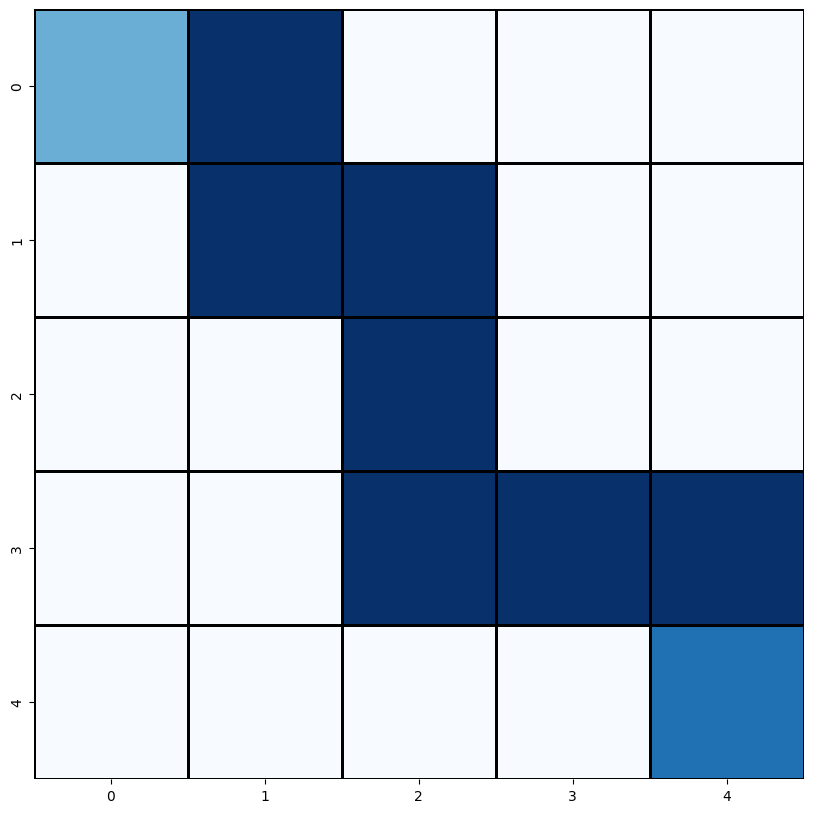

In [218]:
def visualize_path(agent, grid_size, start, goal, is_larger_grid=False):
    env = GridWorld(grid_size, start, goal)
    state = env.reset()
    path = [state]
    done = False
    
    while not done:
        action = agent.choose_action(state)
        state, _, done = env.step(action)
        path.append(state)
    
    grid = np.zeros(grid_size)
    for (x, y) in path:
        grid[x, y] = 1
    
    grid[start] = 0.5  # Mark start position
    grid[goal] = 0.75  # Mark goal position
    
    plt.figure(figsize=(10, 10))
    if is_larger_grid:
        sns.heatmap(grid, linewidths=0.01, linecolor='black', cmap='Blues', cbar=False, square=True)
    else:
        sns.heatmap(grid, linewidths=1, linecolor='black', cmap='Blues', cbar=False, square=True)
    plt.show()
    
visualize_path(agent, small_grid_size, small_start, small_goal)

As we can see from the above plot, the agent successfully navigates the gridworld environment from the start state (0, 0) to the goal state (4, 4) following the optimal path. There are multiple optimal paths, all require 8 steps to reach the goal state. If you re-run the code, the path will change every time.

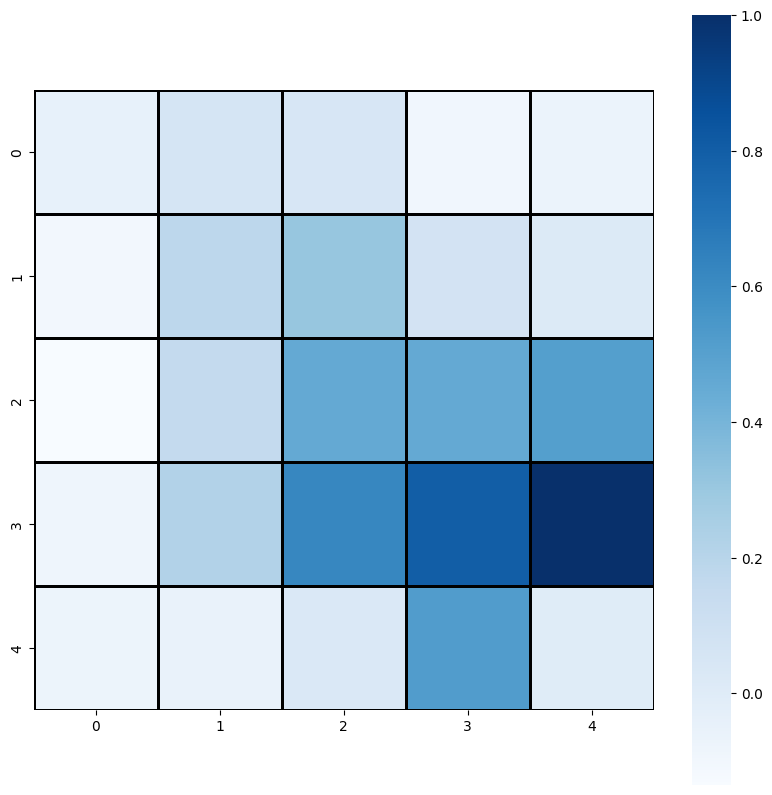

In [219]:
def visualize_q_values(agent):
    q_values = np.max(agent.q_table, axis=2)
    plt.figure(figsize=(10, 10))
    sns.heatmap(q_values, linewidths=1, linecolor='black', cmap='Blues', cbar=True, square=True)
    plt.show()
    
visualize_q_values(agent)

The above plot visualizes the q-values learned by the agent for each state-action pair. The color intensity represents the q-value, with darker colors indicating higher q-values. We can see that the closer to the goal state, the higher the q-values are for the optimal actions.

## **4. Transfer Learning to a Larger Grid**

[Back to Top](#Table-of-Contents)

---

Now, I'll demonstrate how transfer learning can be used to fine-tune the agent on a larger gridworld environment with a 10x10 grid.

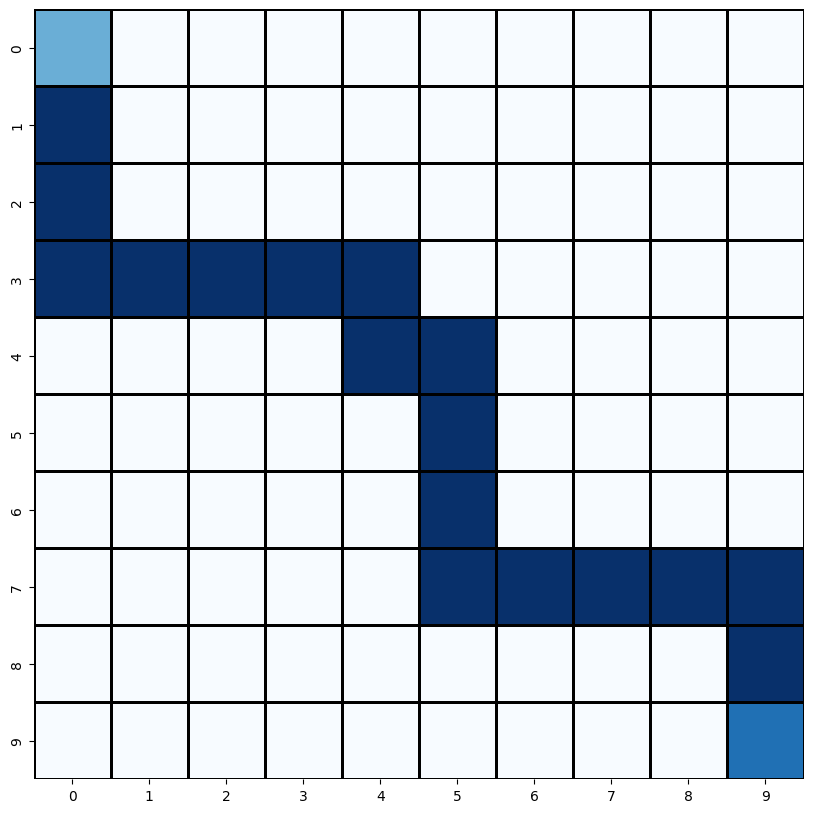

In [220]:
def transfer_to_larger_grid(agent, new_grid_size, new_start, new_goal, episodes):
    agent.update_q_table_larger_grid(new_grid_size)
    env = GridWorld(new_grid_size, new_start, new_goal)
    
    for _ in range(episodes):
        state = env.reset()
        done = False
        
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            
        # Decay epsilon after each episode
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, 0.01)
    
    return agent

large_grid_size = (10, 10)
large_start = (0, 0)
large_goal = (9, 9)
large_grid_episodes = 1000

agent = transfer_to_larger_grid(agent, large_grid_size, large_start, large_goal, large_grid_episodes)
visualize_path(agent, large_grid_size, large_start, large_goal)

For a 10x10 grid, the amount of steps, optimally, is 18. As we can see from the above plot, the agent successfully navigates the gridworld environment from the start state (0, 0) to the goal state (9, 9) following one of the optimal paths.

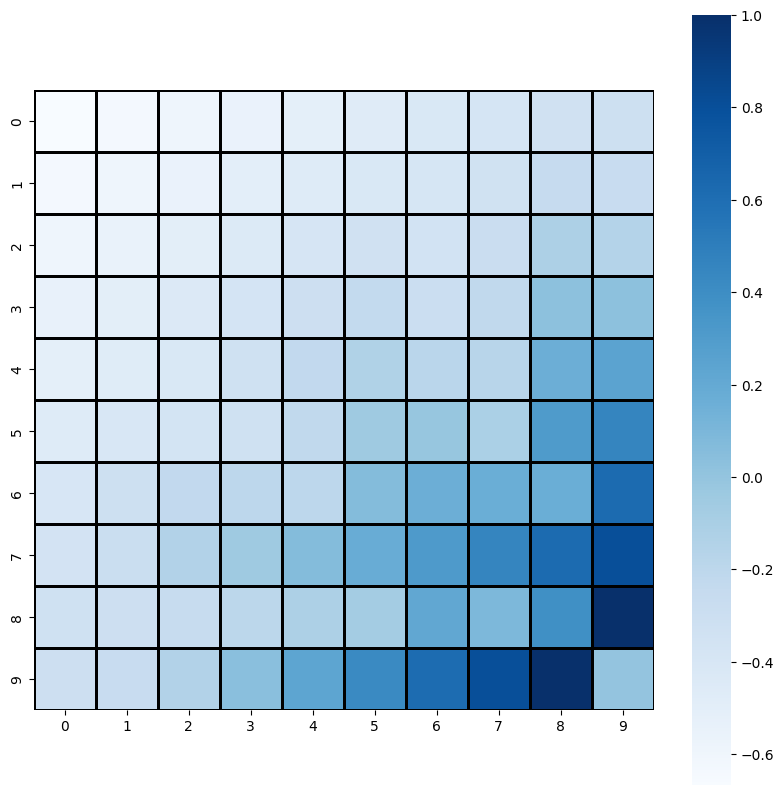

In [221]:
visualize_q_values(agent)

The agent was able to transfer the knowledge learned from the 5x5 grid to the 10x10 grid and successfully navigate the environment to reach the goal state. This demonstrates how one can leverage transfer learning to optimize game strategy across different environments.